In [58]:
#Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
insurance_data_path = 'insurance.csv'
insurance = pd.read_csv(insurance_data_path)
print(insurance.head())

    age     sex     bmi  children smoker     region       charges
0  19.0  female  27.900       0.0    yes  southwest     16884.924
1  18.0    male  33.770       1.0     no  Southeast     1725.5523
2  28.0    male  33.000       3.0     no  southeast     $4449.462
3  33.0    male  22.705       0.0     no  northwest  $21984.47061
4  32.0    male  28.880       0.0     no  northwest    $3866.8552


Let's take a look at the insurance dataset.

In [60]:
print(insurance.info())
print(insurance.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB
None
               age          bmi     children
count  1272.000000  1272.000000  1272.000000
mean     35.214623    30.560550     0.948899
std      22.478251     6.095573     1.303532
min     -64.000000    15.960000    -4.000000
25%      24.750000    26.180000     0.000000
50%      38.000000    30.210000     1.000000
75%      51.000000    34.485000     2.000000
max      64.000000    53.130000     5.000000


Looks like we have a few issues with the data quality:
1. Some null values in every column except charges.
2. We also have negative values in age and children columns.
3. Charges contains a dollar sign and is stored as an object rather than a float.
4. It appears that there are some nulls in each column.

First, let's explore the value counts of each of the categorical columns.

In [61]:
cat_cols = ['sex', 'smoker', 'region', 'charges']

for col in cat_cols:
    print(insurance[col].value_counts())

male      517
female    503
man        64
M          64
woman      62
F          62
Name: sex, dtype: int64
no     1013
yes     259
Name: smoker, dtype: int64
Southeast    172
southeast    170
southwest    164
Northwest    161
Northeast    155
northeast    153
northwest    149
Southwest    148
Name: region, dtype: int64
$nan            12
1639.5631        2
16884.924        1
13555.0049       1
4661.28635       1
                ..
7345.084         1
26109.32905      1
$28287.89766     1
1149.3959        1
29141.3603       1
Name: charges, Length: 1272, dtype: int64


We also see now that we have data entry issues with the sex column and region column. Let's make a few of the necessary cleanings.

We will remove any values below 0 in the children column. We can also assume that insurance will not be permitted to anyone under the age of 16, so we will filter age by 16 and over as well. We will fix the sex entries and then lower the capitalization of region.

Finally, we will remove the nulls from only the charges column since that will be our target variable. We will impute the nulls for the other columns in an upcoming step.

In [62]:
# Remove the dollar sign from charges
insurance['charges'] =  insurance['charges'].str.replace('$', '').astype(float)


# Remove rows when age is below 16
insurance['age'] = insurance['age'].apply(lambda x: x*-1 if x < 16 else x).round()

# Remove rows when children are less than 0
insurance['children'] = insurance['children'].apply(lambda x: x*-1 if x < 0 else x).round()

# Fix sex entries
insurance['sex'] = insurance['sex'].str.replace('man', 'male').str.replace('woman', 'female').str.replace('M', 'male').str.replace('F', 'female').str.replace('womale', 'female')

# Lowercasing region will coalesce all disparate entries
insurance['region'] = insurance['region'].str.lower()

insurance = insurance.dropna(subset=['charges'])

print(insurance.head())

    age     sex     bmi  children smoker     region      charges
0  19.0  female  27.900       0.0    yes  southwest  16884.92400
1  18.0    male  33.770       1.0     no  southeast   1725.55230
2  28.0    male  33.000       3.0     no  southeast   4449.46200
3  33.0    male  22.705       0.0     no  northwest  21984.47061
4  32.0    male  28.880       0.0     no  northwest   3866.85520


C:\Users\Mikey\AppData\Local\Temp\ipykernel_332072\2305135424.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  insurance['charges'] =  insurance['charges'].str.replace('$', '').astype(float)


Next, we'll create a few count and dist plots to further explore the data and ensure we didn't miss anything.

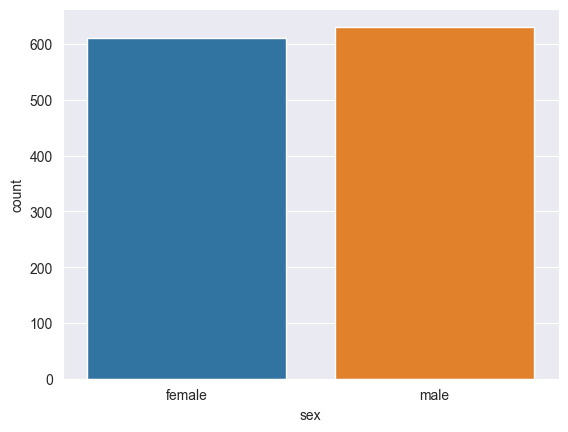

In [63]:
sns.countplot(data=insurance, x='sex')
plt.show()

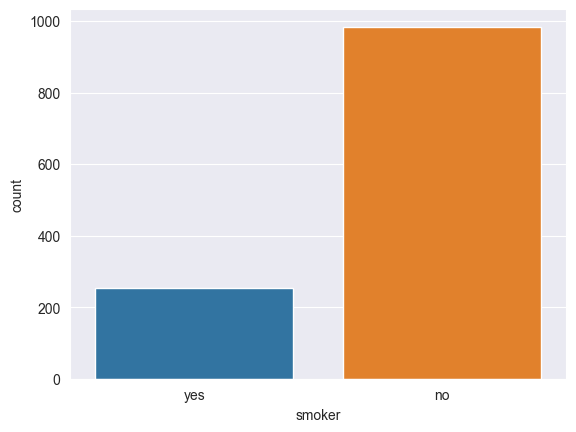

In [64]:
sns.countplot(data=insurance, x='smoker')
plt.show()

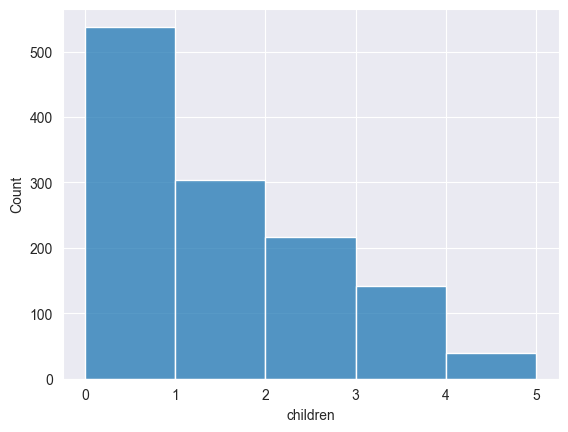

In [65]:
sns.histplot(data=insurance, x='children', binwidth=1)
plt.show()

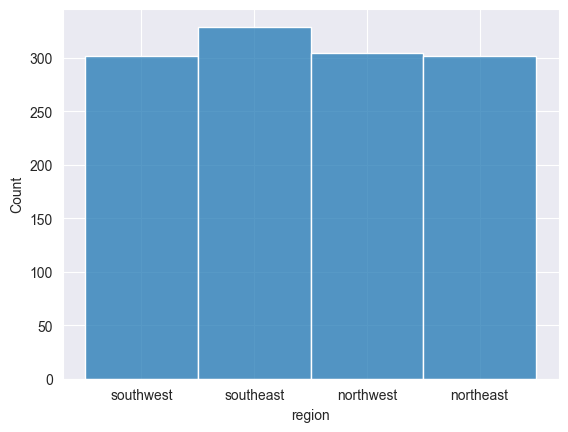

In [66]:
sns.histplot(data=insurance, x='region', binwidth=1)
plt.show()

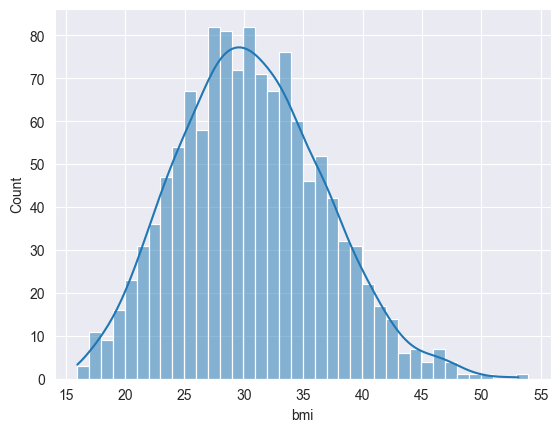

In [67]:
sns.histplot(data=insurance, x='bmi', binwidth=1, kde=True)
plt.show()

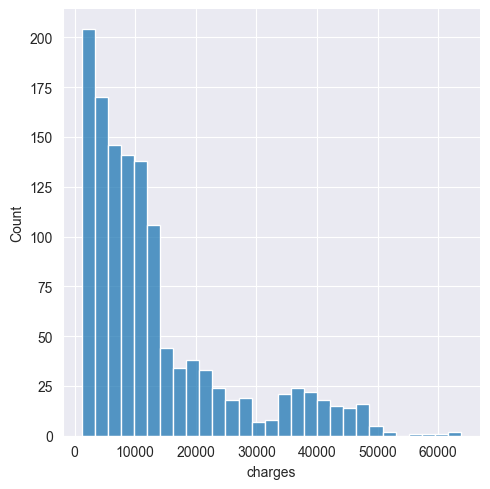

In [68]:
sns.displot(data=insurance, x='charges')
plt.show()

Everything looks great, so now we will set up our preprocessing steps, including imputing categorical columns by mode and numerical columns by median.

In [69]:
categorical_columns = ['sex', 'smoker', 'region']
imp_cat = SimpleImputer(strategy='most_frequent')
for col in categorical_columns:
    insurance[col] = imp_cat.fit_transform(insurance[[col]])

numerical_columns = ['age', 'bmi', 'children']
imp_num = SimpleImputer(strategy='median')
for col in numerical_columns:
    insurance[col] = imp_num.fit_transform(insurance[[col]])

Quickly, let's make sure that there are no duplicates.

In [70]:
print(insurance[insurance.duplicated() == True])

      age   sex    bmi  children smoker     region    charges
581  19.0  male  30.59       0.0     no  northwest  1639.5631


Since we have a duplicate row, let's drop it by selecting the first row.

In [71]:
insurance = insurance.drop_duplicates(keep='first')

Next, let's one-hot encode the categorical columns.

In [72]:
insurance_dummies = pd.get_dummies(insurance[['sex', 'smoker', 'region']], drop_first=True)
insurance_dummies = pd.concat([insurance, insurance_dummies], axis=1)
insurance_dummies = insurance_dummies.drop(['sex', 'smoker', 'region'], axis=1)
print(insurance_dummies.columns)

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


Now we can set up our X and y feature lists with charges as our target variable. We will also scale the numeric columns and instantiate our linear regression model per the instructions. Since we have a separate validation set, we will not need to split this set first.

In [73]:
X = insurance_dummies.drop(columns=['charges'])
y = insurance_dummies['charges']

scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

model = LinearRegression()

We'll use R2 as our scoring method.

In [74]:
model.fit(X, y)
y_pred = model.predict(X)
cv_results = cross_val_score(model, X, y, cv=5, scoring='r2')

r2_score = cv_results.mean()
print(r2_score)

0.7210333750417799


This model explains 72.1% of the variance in predicting insurance charges, exceeding the required 65%. We will continue running this model on our validation set next.

In [75]:
validation_data = pd.read_csv('validation_dataset.csv')

print(validation_data.head())

    age     sex        bmi  children smoker     region
0  18.0  female  24.090000       1.0     no  southeast
1  39.0    male  26.410000       0.0    yes  northeast
2  27.0    male  29.150000       0.0    yes  southeast
3  71.0    male  65.502135      13.0    yes  southeast
4  28.0    male  38.060000       0.0     no  southeast


Let's ensure that the validation set does not need the same cleaning as the training set by viewing the info, describe, and value_counts methods.

In [76]:
print(validation_data.info())
print(validation_data.describe())

for col in ['sex', 'smoker', 'region']:
    print(validation_data[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     object 
 2   bmi       50 non-null     float64
 3   children  50 non-null     float64
 4   smoker    50 non-null     object 
 5   region    50 non-null     object 
dtypes: float64(3), object(3)
memory usage: 2.5+ KB
None
             age        bmi   children
count  50.000000  50.000000  50.000000
mean   46.820000  39.539907   2.780000
std    21.681074  17.725844   4.026899
min    18.000000  18.715000   0.000000
25%    28.000000  27.575000   0.000000
50%    44.500000  33.807500   1.000000
75%    60.750000  40.208750   2.750000
max    92.000000  89.097296  13.000000
female    25
male      25
Name: sex, dtype: int64
no     32
yes    18
Name: smoker, dtype: int64
northwest    16
southeast    14
northeast    11
southwest     9
Name: region, dty

No null values, age is above 18 in this case, and no misspellings. We are clear to use our model on this set.

In [77]:
validation_dummies = pd.get_dummies(validation_data[['sex', 'smoker', 'region']], drop_first=True)
validation_dummies = pd.concat([validation_data, validation_dummies], axis=1)
validation_dummies = validation_dummies.drop(['sex', 'smoker', 'region'], axis=1)

X_test = validation_dummies

scaler = StandardScaler()
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

y_pred_test = model.predict(X_test)
validation_data['predicted_charges'] = y_pred_test
print(validation_data)

     age     sex        bmi  children smoker     region  predicted_charges
0   18.0  female  24.090000       1.0     no  southeast        1598.216065
1   39.0    male  26.410000       0.0    yes  northeast       29625.585584
2   27.0    male  29.150000       0.0    yes  southeast       27323.977240
3   71.0    male  65.502135      13.0    yes  southeast       40470.464791
4   28.0    male  38.060000       0.0     no  southeast        4655.350300
5   70.0  female  72.958351      11.0    yes  southeast       40907.946433
6   29.0  female  32.110000       2.0     no  northwest        4761.161810
7   42.0  female  41.325000       1.0     no  northeast        8133.040753
8   48.0  female  36.575000       0.0     no  northwest        8201.773782
9   63.0    male  33.660000       3.0     no  southeast       10472.637707
10  27.0    male  18.905000       3.0     no  northeast        3340.357745
11  51.0  female  36.670000       2.0     no  northwest        8980.429892
12  60.0  female  24.5300

## Results
After preprocessing, the regression model explained 72.1% of the variance in predicting insurance charges, which surpassed the required 65%. The model then predicted the charges for each of the 50 records in the validation set. None of those predictions had a negative value or were below the minimum basic charge of 1000.